In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

from torchvision.utils import save_image

import pandas as pd

import random

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib import offsetbox

from model_defs import *

import numpy as np

from itertools import chain

from sklearn import (manifold, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

In [2]:
emnist = datasets.EMNIST('./data', train = True, transform = transforms.ToTensor(), split = 'letters', download = True)
emnist_test = datasets.EMNIST('./data', train = False, transform = transforms.ToTensor(), split = 'letters', download = True)

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

Extracting ./data/EMNIST/raw/emnist.zip to ./data/EMNIST/raw
Processing byclass


/opt/conda/conda-bld/pytorch_1591914855613/work/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [3]:
%%time
df_train_ori = pd.DataFrame({'img': [e[0] for e in mnist_train], 'label': [e[1] for e in mnist_train]})
df_train = df_train_ori[df_train_ori.label == 0].reset_index().drop('index',axis = 1)

df_ref = pd.DataFrame({'img': [e[0] for e in emnist], 'label':[e[1] - 1 for e in emnist]})
df_ref_use = df_ref.sample(df_train.shape[0]).reset_index().drop('index', axis = 1)

df_ref_test = pd.DataFrame({'img': [e[0] for e in emnist_test], 'label':[e[1] - 1 for e in emnist_test]})
# df_ref_test = df_ref_test.sample(df_train.shape[0]).reset_index().drop('index', axis = 1)




CPU times: user 44.1 s, sys: 217 ms, total: 44.3 s
Wall time: 47.5 s


In [4]:
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for _,_, data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output, _ = model(data)
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [5]:
batch_size = 100
learning_rate = 1e-3
num_epoch = 30

In [6]:
c_imgs = Char_img(df_train, df_ref)#Char_img(df_train, df_ref_use)
training_loader = DataLoader(c_imgs, batch_size = batch_size, shuffle = True)

In [7]:
c_imgs_test = Char_img(df_train, df_ref_test)
testing_loader = DataLoader(c_imgs_test, batch_size = batch_size, shuffle = True)

In [8]:
model = One_class_net(num_classes = df_ref.label.nunique())
# model.load_state_dict(torch.load('./rep_v1.pth'))
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [9]:
losses = []
for i in tqdm(range(num_epoch)): #num_epochs
    for _,_, r_img, r_l in training_loader:
        r_img = r_img.cuda()
        r_l = r_l.cuda()

        output, _ = model(r_img)
        loss = criterion(output, r_l)

        losses.append(loss.mean().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), './rep_v1.pth')

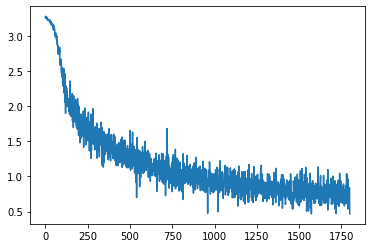

In [10]:
plt.plot(losses)

In [11]:
test(model, testing_loader)


Test set: Average loss: 1.0593, Accuracy: 3986/5923 (67%)



In [14]:
# get mnist zeros imbeddings
loader = testing_loader

zeros_embeddings = torch.zeros(1,64).cuda()

with torch.no_grad():
    for i, (z,_, _, _) in enumerate(loader):
        z = z.cuda()
        _, feat = model(z)
        
        n = feat.shape[0]
        
        zeros_embeddings = torch.cat((zeros_embeddings, feat.view(n,-1)), dim = 0)
        if (i == 5):
            break

zeros_embeddings = zeros_embeddings[1:]
zeros_embeddings = zeros_embeddings.cpu()

In [16]:
# get other imbeddings
loader = training_loader

other_embeddings = torch.zeros(1,64).cuda()

ys = []
with torch.no_grad():
    for i, (_,_, img, y) in enumerate(loader):
        z = z.cuda()
        _, feat = model(z)

        n = feat.shape[0]
        
        other_embeddings = torch.cat((other_embeddings, feat.view(n,-1)), dim = 0)
        ys.append(y)
        if (i == 8):
            break

other_embeddings = other_embeddings[1:]
other_embeddings = other_embeddings.cpu()

In [17]:
ys = torch.tensor(list(chain.from_iterable(ys)))

ys = torch.cat((torch.zeros(zeros_embeddings.shape[0]).int(), ys.int()), dim = 0)

In [18]:
x_embeddings = torch.cat((zeros_embeddings, other_embeddings), dim = 0)

# observe embeddings

In [19]:
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i].item()),
                 color=plt.cm.Set1(y[i].item() / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

#     if hasattr(offsetbox, 'AnnotationBbox'):
#         # only print thumbnails with matplotlib > 1.0
#         shown_images = np.array([[1., 1.]])  # just something big
#         for i in range(X.shape[0]):
#             dist = np.sum((X[i] - shown_images) ** 2, 1)
#             if np.min(dist) < 4e-3:
#                 # don't show points that are too close
#                 continue
#             shown_images = np.r_[shown_images, [X[i]]]
#             imagebox = offsetbox.AnnotationBbox(
#                 offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#                 X[i])
#             ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding


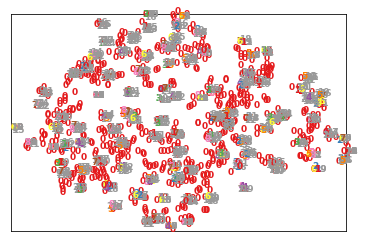

In [20]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(x_embeddings)

plot_embedding(X_tsne, ys)

In [21]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=1).fit(zeros_embeddings)